<a href="https://colab.research.google.com/github/Deven10103/ds_devendra_prasad/blob/main/Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Trading Behavior Analysis: Fear vs Greed

## Objective:
To analyze and compare the effects of market fear and greed periods on trading behavior metrics, using a historical trading dataset and a Fear & Greed Index.

## Datasets Used:
*   `historical_data.csv`: Contains individual trade records including accounts information, Closed PnL, volume, and timestamps.
*   `fear_greed_index.csv`: Provides daily market sentiment classifications (Extreme Fear, Fear, Neutral, Greed, Extreme Greed).

## Notebook Outline:
*   **1. Data Loading and Initial EDA**: Load and inspect `historical_data.csv` and `fear_greed_index.csv`.

*   **2. Fear & Greed Index Analysis**: Explore the distribution and temporal patterns of market sentiment.

*   **3. Trading Data Analysis**: Visualize and study the PnL distribution, daily trade counts, and volume throughout the dataset.

*   **4. Daily Aggregation & Feature Engineering**: Aggregate individual trade data to daily metrics (total trades, unique accounts, total volume, mean PnL) along with addition of new features (volitality, win rate, activity flag).

*   **5. Merge Trading Behavior with Sentiment Data**: Combine trading metrics with the corresponding market on daily data.

*   **6. Behavioral Comparison (Fear vs Greed Regimes)**: Analyze key trading metrics (total trades, unique accounts, total volume, PnL volatility) during periods classified as 'Fear' (Fear, Extreme Fear) versus 'Greed' (Greed, Extreme Greed).

*   **7. Visualizations and Insights**: Generate plots to illustrate the differences in trading behavior across sentiment regimes and summarize key statistical findings.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from google.colab import files
from scipy import stats

pd.set_option('display.float_format', '{:.10f}'.format)

print("\nUpload the fear greed index and historical trades datasets for analysis.")

os.makedirs('/content/csv_files', exist_ok=True)
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(f'/content/{filename}', f'/content/csv_files/{filename}')
    print(f'Moved {filename} to /content/csv_files/')


Upload the fear greed index and historical trades datasets for analysis.


Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv
Moved historical_data.csv to /content/csv_files/
Moved fear_greed_index.csv to /content/csv_files/


## Utility Functions:

In [4]:

def check_date_quality_df(df, date_column, name):
    results = {}

    results['Dataset'] = name
    results['Data_Type'] = str(df[date_column].dtype)
    results['Total_Rows'] = len(df)
    results['Missing_Dates'] = df[date_column].isna().sum()

    if df[date_column].dtype != 'datetime64[ns]':
        try:
            parsed_dates = pd.to_datetime(df[date_column], errors='coerce')
            results['Parsing_Errors'] = parsed_dates.isna().sum() - results['Missing_Dates']
            date_series = parsed_dates
        except:
            results['Parsing_Errors'] = np.nan
            date_series = None
    else:
        results['Parsing_Errors'] = 0
        date_series = df[date_column]

    results['Duplicate_Dates'] = df[date_column].duplicated().sum()

    if date_series is not None and (pd.api.types.is_datetime64_any_dtype(date_series) or date_series.dtype == 'datetime64[ns]'):
        date_only = date_series.dt.normalize()

        results['Earliest_Date'] = str(date_series.min())
        results['Latest_Date'] = str(date_series.max())
        results['Date_Span_Days'] = (date_only.max() - date_only.min()).days

        date_diff = date_series.diff()
        results['Max_Gap_Between_Dates'] = str(date_diff.max())

        unique_dates = date_only.unique()
        expected_rows = (date_only.max() - date_only.min()).days + 1
        actual_unique_days = len(unique_dates)

        results['Expected_Daily_Entries'] = expected_rows
        results['Unique_Days'] = actual_unique_days
        results['Missing_Days'] = expected_rows - actual_unique_days
        results['Total_Records'] = len(df)
    else:
        results['Earliest_Date'] = np.nan
        results['Latest_Date'] = np.nan
        results['Date_Span_Days'] = np.nan
        results['Max_Gap_Between_Dates'] = np.nan
        results['Expected_Daily_Entries'] = np.nan
        results['Unique_Days'] = np.nan
        results['Missing_Days'] = np.nan
        results['Total_Records'] = np.nan

    results_df = pd.DataFrame([results])

    return results_df

# Exploratory Data Analysis: Fear Greed Index

The following code performs data quality checks and visualizes the Fear & Greed Index across multiple views—overall distribution, temporal heatmap, daily sentiment evolution, and monthly aggregation—to uncover sentiment dominance, clustering, and regime persistence over time.

DATE QUALITY CHECK: FEAR & GREED INDEX DATASET
--------------------------------------------------------------------------------


,0
Dataset,Fear Greed Index
Data_Type,datetime64[ns]
Total_Rows,2644
Missing_Dates,0
Parsing_Errors,0
Duplicate_Dates,0
Earliest_Date,2018-02-01 00:00:00
Latest_Date,2025-05-02 00:00:00
Date_Span_Days,2647
Max_Gap_Between_Dates,4 days 00:00:00


,count
classification,
Fear,781
Greed,633
Extreme Fear,508
Neutral,396
Extreme Greed,326


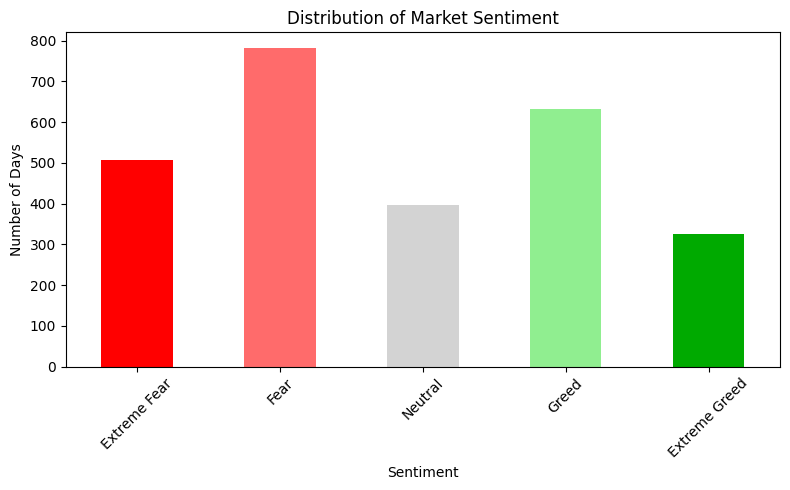


 Conclusion: Majority of the days were lead by fear and extreme fear while extreme greed has the least frequency. 
 	 This shows the cautious behaviour of the market and its sensitivivity in the given period.



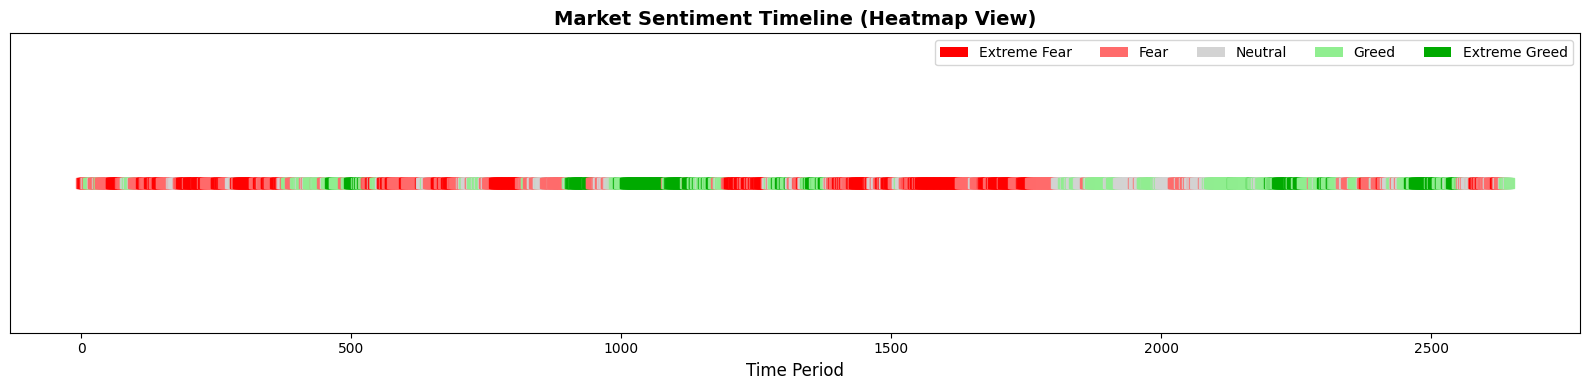


 Conclusion: Sentiment clusters reveal distinct fear and greed regions with regime transitions difficult to identify.



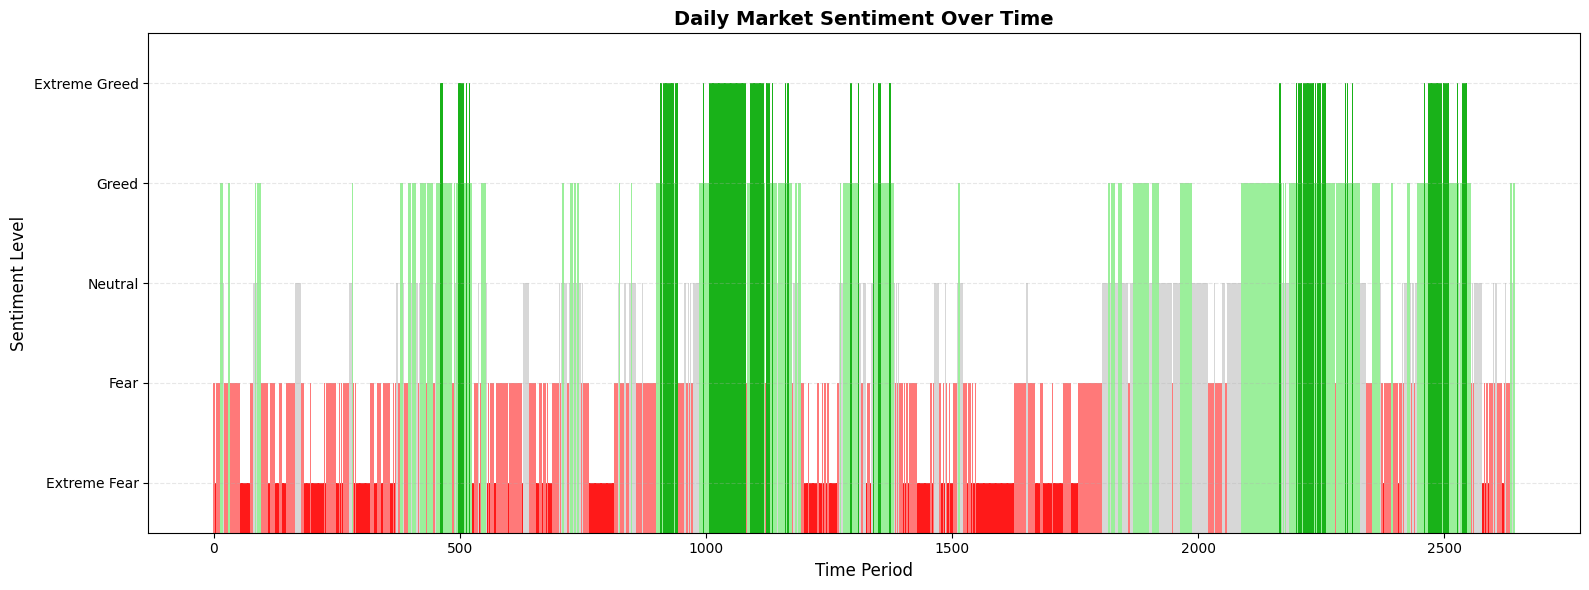


 Conclusion:Further justifies the volatility in sentiment, with periodic spikes into extreme fear and greed zones.
 	 The fear states are fragmented but frequent while greed states are dense and clustered showing volitality. 
 	 Also Extreme greed is a late-cycle signal.



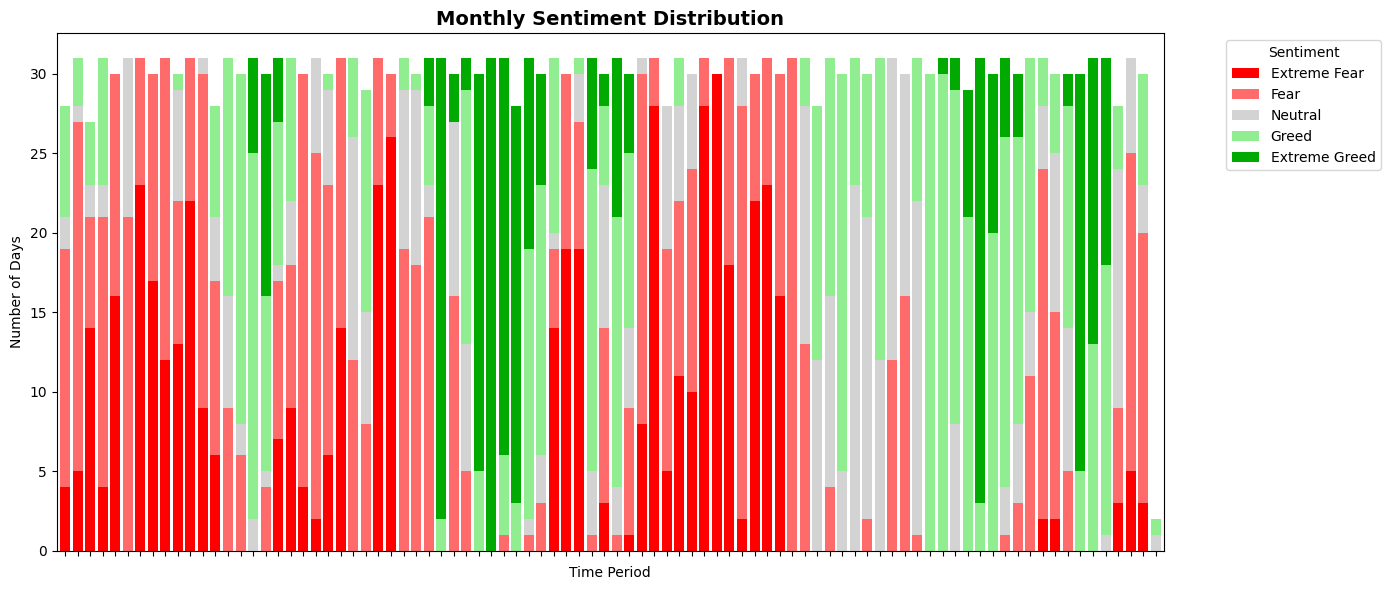


 Conclusion: It shows sentiment is clustered. Once a regime starts, it tends to persist for weeks(specifically months). 
 	 Monthly aggregation confirms sustained monthly fear periods with sporadic greed interval throughout the timeline.



In [5]:

fg_df = pd.read_csv("/content/csv_files/fear_greed_index.csv")
fg_df['date'] = pd.to_datetime(fg_df['date'])
fg_df = fg_df.sort_values('date')

fg_df['time_dummy'] = range(len(fg_df))

date_quality_df = check_date_quality_df(fg_df, 'date', 'Fear Greed Index')

print("DATE QUALITY CHECK: FEAR & GREED INDEX DATASET")
print("-"*80)
display(date_quality_df.T)
print("\n")

date_quality_df.to_csv('/content/csv_files/fg_df_date_check.csv', index=False)

sentiment_counts = fg_df['classification'].value_counts()
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_counts_ordered = sentiment_counts.reindex(sentiment_order, fill_value=0)

display(sentiment_counts)

# Plot 1: Bar chart showing distribution of sentiment categories
plt.figure(figsize=(8,5))
sentiment_counts_ordered.plot(kind='bar', color=['#FF0000', '#FF6B6B', '#D3D3D3', '#90EE90', '#00AA00'])
plt.title("Distribution of Market Sentiment")
plt.ylabel("Number of Days")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n Conclusion: Majority of the days were lead by fear and extreme fear while extreme greed has the least frequency. \n \t This shows the cautious behaviour of the market and its sensitivivity in the given period.\n")

# Plot 2: Horizontal heatmap showing temporal sentiment patterns
sentiment_mapping = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
fg_df['Sentiment_numeric'] = fg_df['classification'].map(sentiment_mapping)

color_map = {
    0: '#FF0000',
    1: '#FF6B6B',
    2: '#D3D3D3',
    3: '#90EE90',
    4: '#00AA00'
}
colors = fg_df['Sentiment_numeric'].map(color_map)

fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(fg_df['time_dummy'], [1]*len(fg_df), c=colors, s=50, marker='s', alpha=0.9)
ax.set_ylim(0.5, 1.5)
ax.set_yticks([])
ax.set_title("Market Sentiment Timeline (Heatmap View)", fontsize=14, fontweight='bold')
ax.set_xlabel("Time Period", fontsize=12)

legend_elements = [
    Patch(facecolor='#FF0000', label='Extreme Fear'),
    Patch(facecolor='#FF6B6B', label='Fear'),
    Patch(facecolor='#D3D3D3', label='Neutral'),
    Patch(facecolor='#90EE90', label='Greed'),
    Patch(facecolor='#00AA00', label='Extreme Greed')
]
ax.legend(handles=legend_elements, loc='upper right', ncol=5)
plt.tight_layout()
plt.show()
print("\n Conclusion: Sentiment clusters reveal distinct fear and greed regions with regime transitions difficult to identify.\n")

# Plot 3: Stacked bar chart showing daily sentiment levels over time
fig, ax = plt.subplots(figsize=(16, 6))

sentiment_y_mapping = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}

fg_df['y_position'] = fg_df['classification'].map(sentiment_y_mapping)

color_map = {
    'Extreme Fear': '#FF0000',
    'Fear': '#FF6B6B',
    'Neutral': '#D3D3D3',
    'Greed': '#90EE90',
    'Extreme Greed': '#00AA00'
}

colors = fg_df['classification'].map(color_map)

ax.bar(fg_df['time_dummy'], fg_df['y_position'], color=colors, width=1.0, alpha=0.9)

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

ax.set_title("Daily Market Sentiment Over Time", fontsize=14, fontweight='bold')
ax.set_xlabel("Time Period", fontsize=12)
ax.set_ylabel("Sentiment Level", fontsize=12)
ax.set_ylim(0.5, 5.5)

ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("\n Conclusion:Further justifies the volatility in sentiment, with periodic spikes into extreme fear and greed zones.\n \t The fear states are fragmented but frequent while greed states are dense and clustered showing volitality. \n \t Also Extreme greed is a late-cycle signal.\n")

# Plot 4: Monthly aggregated sentiment distribution (stacked bar chart)
fg_df['month'] = fg_df['date'].dt.to_period('M')
monthly_data = fg_df.groupby(['month', 'classification']).size().unstack(fill_value=0)

sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
monthly_data = monthly_data[[col for col in sentiment_order if col in monthly_data.columns]]

monthly_data['time_dummy'] = range(len(monthly_data))

fig, ax = plt.subplots(figsize=(14, 6))
monthly_data.plot(x='time_dummy', kind='bar', stacked=True,
                  color=['#FF0000', '#FF6B6B', '#D3D3D3', '#90EE90', '#00AA00'],
                  ax=ax, width=0.8)
ax.set_title("Monthly Sentiment Distribution", fontsize=14, fontweight='bold')
ax.set_xlabel("Time Period")
ax.set_ylabel("Number of Days")
ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels([])
plt.tight_layout()
plt.show()
print("\n Conclusion: It shows sentiment is clustered. Once a regime starts, it tends to persist for weeks(specifically months). \n \t Monthly aggregation confirms sustained monthly fear periods with sporadic greed interval throughout the timeline.\n")

# Exploratory Data Analysis: Historical Trading Dataset(pnL)

The following code validates historical trade timestamps and analyzes realized PnL behavior through distributional and temporal views to check profitability and trading activity consistency.

This analysis reveals whether profitability is driven by trade frequency or payoff asymmetry, exposes skew and tail risk and gain–loss asymmetry in the trading data.


DATE QUALITY CHECK: HISTORICAL TRADES DATA
--------------------------------------------------------------------------------


,0
Dataset,Historical Trades Data
Data_Type,object
Total_Rows,211224
Missing_Dates,0
Parsing_Errors,0
Duplicate_Dates,210744
Earliest_Date,2023-05-01 00:00:00
Latest_Date,2025-05-01 00:00:00
Date_Span_Days,731
Max_Gap_Between_Dates,255 days 00:00:00


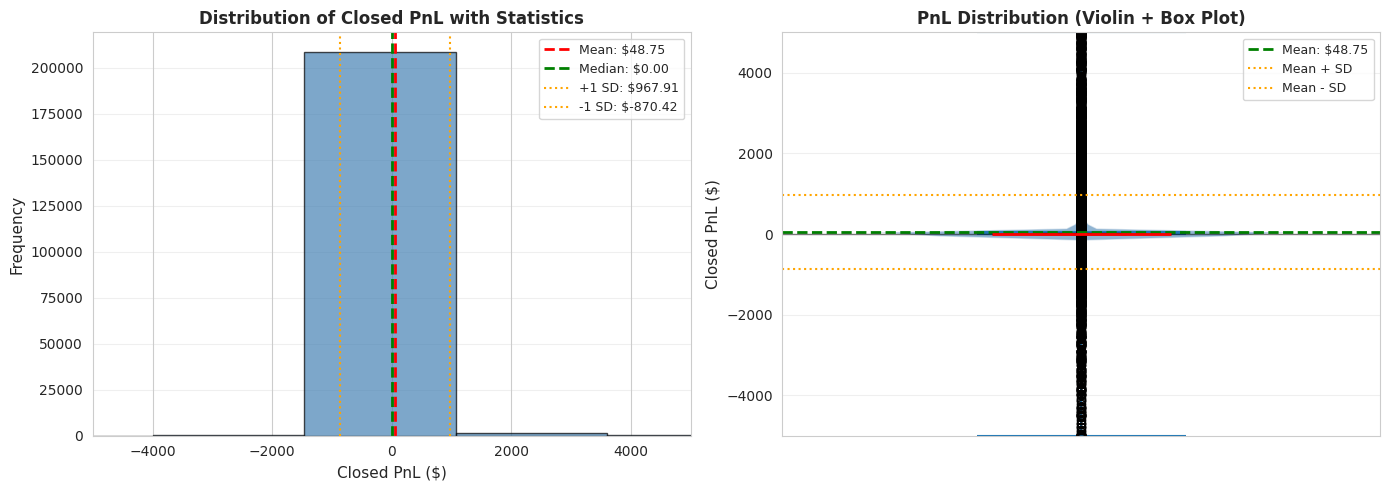


 Conclusion: The PnL distribution is sharply peaked around zero with fat tails, indicating a low per-trade edge where overall profitability is driven by rare events.
 	 The elongated tails and compressed interquartile range reveal non-Gaussian returns, where tail risk dominates variance.



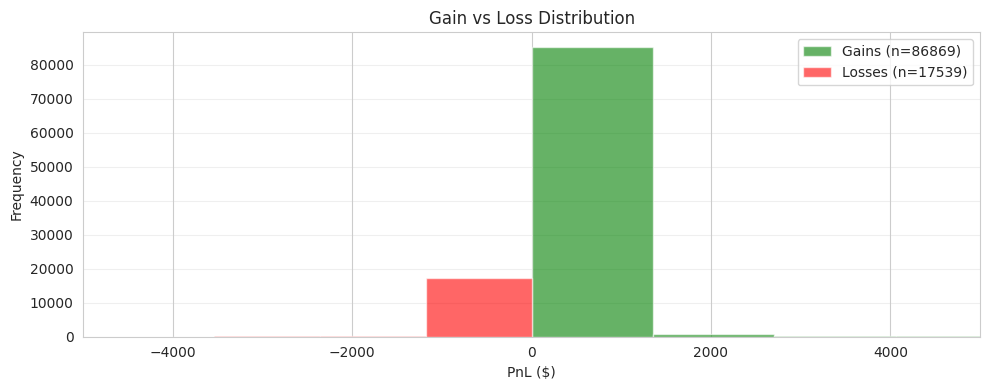


 Conclusion: Gains (86869) slightly outnumber losses (17539), suggesting positive trade frequency bias.
 	 Despite this, the asymmetric loss tail suggests insignificant or small positive payoffs, making the strategy highly sensitive to avoid high loss magnitude.



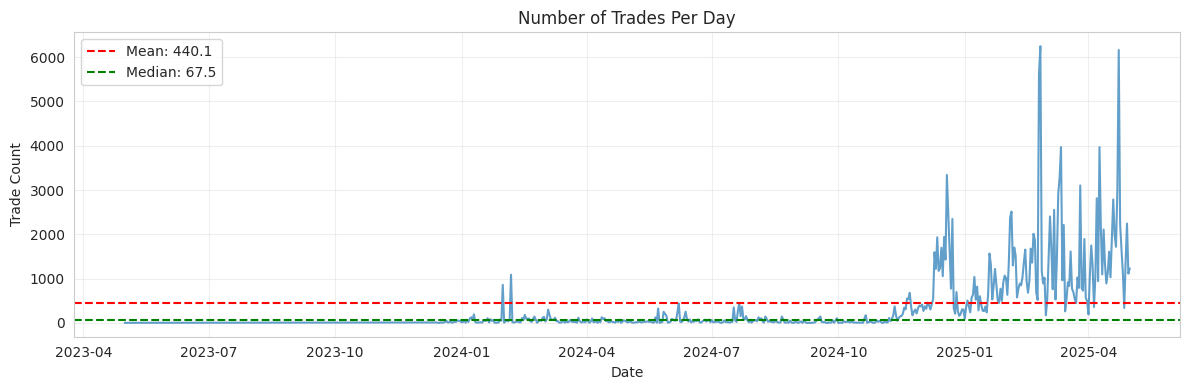


 Conclusion: Daily trading activity shows 480 active days with mean 440.1 trades/day, max 6246 trades/day.
 	 The extreme divergence between mean and median trade counts confirms sentiment-dependent activity clustering, where risk and PnL are concentrated in high-intensity trading periods. 

PNL STATISTICS SUMMARY
--------------------------------------------------------------------------------
Mean: $48.75
Median: $0.00
Std Dev: $919.16
Min: $-117990.10
Max: $135329.09


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

trades = pd.read_csv("/content/csv_files/historical_data.csv")
trades['datetime'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')
trades['date'] = trades['datetime'].dt.date
trades.set_index('Trade ID', inplace=True)

date_quality_df = check_date_quality_df(trades, 'date', 'Historical Trades Data')

print("DATE QUALITY CHECK: HISTORICAL TRADES DATA")
print("-"*80)
display(date_quality_df.T)
print("\n")

invalid_count = trades['Closed PnL'].isna().sum()
closed_trades = trades.dropna(subset=['Closed PnL'])

mean_pnl = closed_trades['Closed PnL'].mean()
std_pnl = closed_trades['Closed PnL'].std()
median_pnl = closed_trades['Closed PnL'].median()

# Plot 1: Histogram showing PnL distribution with statistical markers
# Plot 2: Combined violin and box plot for PnL distribution visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(closed_trades['Closed PnL'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(mean_pnl, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_pnl:.2f}')
ax1.axvline(median_pnl, color='green', linestyle='--', linewidth=2, label=f'Median: ${median_pnl:.2f}')
ax1.axvline(mean_pnl + std_pnl, color='orange', linestyle=':', linewidth=1.5, label=f'+1 SD: ${mean_pnl + std_pnl:.2f}')
ax1.axvline(mean_pnl - std_pnl, color='orange', linestyle=':', linewidth=1.5, label=f'-1 SD: ${mean_pnl - std_pnl:.2f}')
ax1.set_xlabel("Closed PnL ($)", fontsize=11)
ax1.set_ylabel("Frequency", fontsize=11)
ax1.set_title("Distribution of Closed PnL with Statistics", fontsize=12, fontweight='bold')
ax1.set_xlim(-5000, 5000)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

parts = ax2.violinplot([closed_trades['Closed PnL'].clip(-5000, 5000)],
                        positions=[0], vert=True, widths=0.7,
                        showmeans=True, showmedians=True)

for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_alpha(0.6)

bp = ax2.boxplot([closed_trades['Closed PnL'].clip(-5000, 5000)],
                  positions=[0], widths=0.3, vert=True,
                  patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2),
                  meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

ax2.axhline(mean_pnl, color='green', linestyle='--', linewidth=2, label=f'Mean: ${mean_pnl:.2f}')
ax2.axhline(mean_pnl + std_pnl, color='orange', linestyle=':', linewidth=1.5, label=f'Mean + SD')
ax2.axhline(mean_pnl - std_pnl, color='orange', linestyle=':', linewidth=1.5, label=f'Mean - SD')
ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

ax2.set_ylabel("Closed PnL ($)", fontsize=11)
ax2.set_title("PnL Distribution (Violin + Box Plot)", fontsize=12, fontweight='bold')
ax2.set_ylim(-5000, 5000)
ax2.set_xticks([])
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print("\n Conclusion: The PnL distribution is sharply peaked around zero with fat tails, indicating a low per-trade edge where overall profitability is driven by rare events.\n \t The elongated tails and compressed interquartile range reveal non-Gaussian returns, where tail risk dominates variance.\n")

# Plot 3: Overlapping histogram comparing gains vs losses
gains = closed_trades[closed_trades['Closed PnL'] > 0]['Closed PnL']
losses = closed_trades[closed_trades['Closed PnL'] < 0]['Closed PnL']

plt.figure(figsize=(10,4))
plt.hist(gains, bins=100, alpha=0.6, label=f'Gains (n={len(gains)})', color='green')
plt.hist(losses, bins=100, alpha=0.6, label=f'Losses (n={len(losses)})', color='red')
plt.xlim(-5000, 5000)
plt.xlabel("PnL ($)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Gain vs Loss Distribution")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\n Conclusion: Gains ({len(gains)}) slightly outnumber losses ({len(losses)}), suggesting positive trade frequency bias.\n \t Despite this, the asymmetric loss tail suggests insignificant or small positive payoffs, making the strategy highly sensitive to avoid high loss magnitude.\n")

# Plot 4: Time series showing daily trading activity
daily_trades = trades.groupby('date').size()

plt.figure(figsize=(12,4))
plt.plot(daily_trades.index, daily_trades.values, alpha=0.7)
plt.axhline(daily_trades.mean(), color='red', linestyle='--', label=f'Mean: {daily_trades.mean():.1f}')
plt.axhline(daily_trades.median(), color='green', linestyle='--', label=f'Median: {daily_trades.median():.1f}')
plt.title("Number of Trades Per Day")
plt.xlabel("Date")
plt.ylabel("Trade Count")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\n Conclusion: Daily trading activity shows {len(daily_trades)} active days with mean {daily_trades.mean():.1f} trades/day, max {daily_trades.max()} trades/day.\n \t The extreme divergence between mean and median trade counts confirms sentiment-dependent activity clustering, where risk and PnL are concentrated in high-intensity trading periods. \n")

print("PNL STATISTICS SUMMARY")
print("-"*80)
print(f"Mean: ${mean_pnl:.2f}")
print(f"Median: ${median_pnl:.2f}")
print(f"Std Dev: ${std_pnl:.2f}")
print(f"Min: ${closed_trades['Closed PnL'].min():.2f}")
print(f"Max: ${closed_trades['Closed PnL'].max():.2f}")

### Daily Market Activity & Account based Behavior Analysis

The following code aggregates raw trade logs into day-level market metrics and account-level trading profiles, transforming event data into structured data that capture activity, profitability dispersion, risk variability, and participant behavior.

It exposes whether outcomes are driven by market sentiments or by a few dominant accounts, reveals concentration and overtrading risk, and creates the exact feature set needed for sentiment–performance coupling and behavioral diagnostics of each account.


In [7]:
import pandas as pd
import numpy as np

trades = pd.read_csv("/content/csv_files/historical_data.csv")
trades['datetime'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')
trades['date'] = trades['datetime'].dt.date
trades.set_index('Trade ID', inplace=True)

daily_stats = []

for date in trades['date'].dropna().unique():
    daily_data = trades[trades['date'] == date]
    daily_closed = daily_data.dropna(subset=['Closed PnL'])

    total_trades = len(daily_data)
    unique_accounts = daily_data['Account'].nunique()
    total_volume_usd = daily_data['Size USD'].sum()

    mean_closed_pnl = daily_closed['Closed PnL'].mean() if len(daily_closed) > 0 else np.nan
    median_closed_pnl = daily_closed['Closed PnL'].median() if len(daily_closed) > 0 else np.nan
    pnl_volatility = daily_closed['Closed PnL'].std() if len(daily_closed) > 0 else np.nan
    win_rate = (daily_closed['Closed PnL'] > 0).sum() / len(daily_closed) if len(daily_closed) > 0 else np.nan

    daily_stats.append({
        'date': date,
        'total_trades': total_trades,
        'unique_accounts': unique_accounts,
        'total_volume_usd': total_volume_usd,
        'mean_closed_pnl': mean_closed_pnl,
        'median_closed_pnl': median_closed_pnl,
        'pnl_volatility': pnl_volatility,
        'win_rate': win_rate
    })

daily_market_activity = pd.DataFrame(daily_stats)
daily_market_activity = daily_market_activity.sort_values('date').reset_index(drop=True)

display(daily_market_activity.head())
daily_market_activity.to_csv('/content/csv_files/daily_market_activity.csv', index=False)

closed_trades = trades.dropna(subset=['Closed PnL'])
trade_outcomes_distribution = closed_trades[['date', 'Closed PnL', 'Side', 'Size USD']].copy()
trade_outcomes_distribution.columns = ['date', 'closed_pnl', 'side', 'size_usd']
trade_outcomes_distribution = trade_outcomes_distribution.sort_values('date').reset_index(drop=True)

display(trade_outcomes_distribution.head())
trade_outcomes_distribution.to_csv('/content/csv_files/trade_outcomes_distribution.csv', index=False)

print(f"\nDataset 1: daily_market_activity.csv")
print(f"Rows: {len(daily_market_activity)}")
print(f"Columns: {list(daily_market_activity.columns)}")

print(f"\nDataset 2: trade_outcomes_distribution.csv")
print(f"Rows: {len(trade_outcomes_distribution)}")
print(f"Columns: {list(trade_outcomes_distribution.columns)}")

,date,total_trades,unique_accounts,total_volume_usd,mean_closed_pnl,median_closed_pnl,pnl_volatility,win_rate
0,2023-05-01,3,1,477.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,2023-12-05,9,1,50005.8300000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,2023-12-14,11,1,113203.3500000000,-18.6758851818,0.0000000000,179.6635338309,0.3636363636
3,2023-12-15,2,1,10609.9500000000,-12.3160170000,-12.3160170000,4.4743044250,0.0000000000
4,2023-12-16,3,1,15348.7700000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


,date,closed_pnl,side,size_usd
0,2023-05-01,0.0000000000,BUY,137.0800000000
1,2023-05-01,0.0000000000,BUY,183.5300000000
2,2023-05-01,0.0000000000,BUY,156.3900000000
3,2023-12-05,0.0000000000,SELL,24370.6200000000
4,2023-12-05,0.0000000000,SELL,628.0000000000



Dataset 1: daily_market_activity.csv
Rows: 480
Columns: ['date', 'total_trades', 'unique_accounts', 'total_volume_usd', 'mean_closed_pnl', 'median_closed_pnl', 'pnl_volatility', 'win_rate']

Dataset 2: trade_outcomes_distribution.csv
Rows: 211224
Columns: ['date', 'closed_pnl', 'side', 'size_usd']


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.float_format', '{:.10f}'.format)

unique_accounts = trades['Account'].unique()

account_stats = []
for account in trades['Account'].unique():
    account_trades = trades[trades['Account'] == account]

    td = account_trades['date'].nunique()
    td_buys = account_trades[account_trades['Side'] == "BUY"]['date'].nunique()
    td_sells = account_trades[account_trades['Side'] == "SELL"]['date'].nunique()

    buy_sum = account_trades[account_trades['Side'] == 'BUY']['Size USD'].sum()
    sell_sum = account_trades[account_trades['Side'] == 'SELL']['Size USD'].sum()
    total_volume = account_trades['Size USD'].sum()

    avg_trades_per_day = len(account_trades) / td if td > 0 else 0
    avg_daily_volume = total_volume / td if td > 0 else 0
    avg_daily_buy_volume = buy_sum / td_buys if td_buys > 0 else 0
    avg_daily_sell_volume = sell_sum / td_sells if td_sells > 0 else 0
    buy_sell_ratio = buy_sum / sell_sum if sell_sum > 0 else None

    max_daily_volume = account_trades.groupby('date')['Size USD'].sum().max()
    concentration = max_daily_volume / total_volume if total_volume > 0 else 0

    account_stats.append({
        'Account': account,
        'Total_Trades': len(account_trades),
        'Trading_Days': td,
        'Avg_Trades_Per_Day': avg_trades_per_day,
        'Avg_Daily_Volume_USD': avg_daily_volume,
        'Avg_Daily_Buy_Volume': avg_daily_buy_volume,
        'Avg_Daily_Sell_Volume': avg_daily_sell_volume,
        'Buy_Sell_Volume_Ratio': buy_sell_ratio,
        'Max_Day_Volume_Share': concentration
    })

account_stats_df = pd.DataFrame(account_stats)
account_stats_df = account_stats_df.sort_values(by='Total_Trades', ascending=False, ignore_index=True).round(2)

display(account_stats_df.head())
print(f"\nDataset: accounts_trade_frequency.csv")
print(f"Total accounts: {len(account_stats_df)}")
print(f"Columns: {list(account_stats_df.columns)}")
account_stats_df.to_csv('/content/csv_files/accounts_trade_frequency.csv', index=False)

,Account,Total_Trades,Trading_Days,Avg_Trades_Per_Day,Avg_Daily_Volume_USD,Avg_Daily_Buy_Volume,Avg_Daily_Sell_Volume,Buy_Sell_Volume_Ratio,Max_Day_Volume_Share
0,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,131,306.7500000000,565708.4800000000,283901.9100000000,299748.9400000000,0.9600000000,0.0700000000
1,0xbaaaf6571ab7d571043ff1e313a9609a10637864,21192,28,756.8600000000,2429869.2900000000,1510927.2500000000,1512866.9900000000,0.9600000000,0.1500000000
2,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,15605,64,243.8300000000,310440.7500000000,155162.6300000000,218045.2200000000,0.9400000000,0.0800000000
3,0x8477e447846c758f5a675856001ea72298fd9cb5,14998,174,86.2000000000,70717.1700000000,41178.6100000000,38814.7100000000,0.9800000000,0.1000000000
4,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,256,57.5500000000,220873.3000000000,148084.6400000000,155748.2100000000,0.9100000000,0.1400000000



Dataset: accounts_trade_frequency.csv
Total accounts: 32
Columns: ['Account', 'Total_Trades', 'Trading_Days', 'Avg_Trades_Per_Day', 'Avg_Daily_Volume_USD', 'Avg_Daily_Buy_Volume', 'Avg_Daily_Sell_Volume', 'Buy_Sell_Volume_Ratio', 'Max_Day_Volume_Share']


### Daily Trade Activity Feature Engineering

The following code resamples intraday trade logs into a daily time series with additional behavioral and risk featureslike win rate, PnL dispersion, volume intensity, and activity flags—to create a clean, sentiment-aware representation of market participation.
It defines “active” trading days, quantifies day-level risk and efficiency, and produces features that are directly usable for volatility modeling, sentiment alignment.

In [9]:
import pandas as pd
import numpy as np

trades = pd.read_csv("/content/csv_files/historical_data.csv")
trades['datetime'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')
trades['date'] = trades['datetime'].dt.date
trades.set_index('Trade ID', inplace=True)

daily_stats = []

for date in sorted(trades['date'].dropna().unique()):
    daily_data = trades[trades['date'] == date]
    daily_closed = daily_data.dropna(subset=['Closed PnL'])

    total_trades = len(daily_data)
    unique_accounts = daily_data['Account'].nunique()
    total_volume_usd = daily_data['Size USD'].abs().sum()

    mean_closed_pnl = daily_closed['Closed PnL'].mean() if len(daily_closed) > 0 else np.nan
    median_closed_pnl = daily_closed['Closed PnL'].median() if len(daily_closed) > 0 else np.nan
    pnl_volatility = daily_closed['Closed PnL'].std() if len(daily_closed) > 0 else np.nan

    winning_trades = (daily_closed['Closed PnL'] > 0).sum()
    total_closed_trades = len(daily_closed[daily_closed['Closed PnL'] != 0])
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else np.nan

    daily_stats.append({
        'date': date,
        'total_trades': total_trades,
        'unique_accounts': unique_accounts,
        'total_volume_usd': total_volume_usd,
        'mean_closed_pnl': mean_closed_pnl,
        'median_closed_pnl': median_closed_pnl,
        'pnl_volatility': pnl_volatility,
        'win_rate': win_rate
    })

daily_trader_behavior = pd.DataFrame(daily_stats)
daily_trader_behavior['date'] = pd.to_datetime(daily_trader_behavior['date'])
daily_trader_behavior = daily_trader_behavior.sort_values('date').reset_index(drop=True)

MIN_TRADES = 5
MIN_ACCOUNTS = 1

daily_trader_behavior['activity_flag'] = (
    (daily_trader_behavior['total_trades'] >= MIN_TRADES) &
    (daily_trader_behavior['unique_accounts'] >= MIN_ACCOUNTS)
)

low_activity_days = (~daily_trader_behavior['activity_flag']).sum()

display(daily_trader_behavior.head(10))
print(f"\nDataset: daily_trader_behavior.csv")
print(f"Total days: {len(daily_trader_behavior)}")
print(f"Low activity days (flagged): {low_activity_days}")
print(f"Date range: {daily_trader_behavior['date'].min()} to {daily_trader_behavior['date'].max()}")

daily_trader_behavior.to_csv('/content/csv_files/daily_trader_behavior.csv', index=False)

,date,total_trades,unique_accounts,total_volume_usd,mean_closed_pnl,median_closed_pnl,pnl_volatility,win_rate,activity_flag
0,2023-05-01,3,1,477.0000000000,0.0000000000,0.0000000000,0.0000000000,NaN,False
1,2023-12-05,9,1,50005.8300000000,0.0000000000,0.0000000000,0.0000000000,NaN,True
2,2023-12-14,11,1,113203.3500000000,-18.6758851818,0.0000000000,179.6635338309,0.6666666667,True
3,2023-12-15,2,1,10609.9500000000,-12.3160170000,-12.3160170000,4.4743044250,0.0000000000,False
4,2023-12-16,3,1,15348.7700000000,0.0000000000,0.0000000000,0.0000000000,NaN,False
5,2023-12-17,14,1,116278.0200000000,21.7844846429,0.0267600000,43.5126168343,0.6363636364,True
6,2023-12-18,2,1,31164.1800000000,0.0000000000,0.0000000000,0.0000000000,NaN,False
7,2023-12-19,15,1,91602.4100000000,66.7025741333,4.5025670000,183.7353701174,1.0000000000,True
8,2023-12-20,18,1,141636.7900000000,9.0406823333,0.0000000000,21.3481314287,1.0000000000,True
9,2023-12-21,49,1,125233.9700000000,10.9634980000,0.0325920000,20.8116247357,0.9629629630,True



Dataset: daily_trader_behavior.csv
Total days: 480
Low activity days (flagged): 27
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


### Trade–Sentiment Alignment [Temporal Join]

The following code merges daily trader behavior features with market sentiment labels using a left join, aligning sentiment context only where trade activity exists and preserving trade-driven analysis window.

This step combines behavior with psychology. It produces the final modeling table needed to study how fear and greed regimes condition volume, volatility, and win-rate dynamics.


In [10]:
import pandas as pd
import numpy as np

daily_trader_behavior = pd.read_csv('/content/csv_files/daily_trader_behavior.csv')
daily_trader_behavior['date'] = pd.to_datetime(daily_trader_behavior['date'])

fg_df = pd.read_csv("/content/csv_files/fear_greed_index.csv")
fg_df['date'] = pd.to_datetime(fg_df['date'])

sentiment_df = fg_df[['date', 'classification']].copy()
sentiment_df.columns = ['date', 'sentiment']

daily_behavior_with_sentiment = daily_trader_behavior.merge(
    sentiment_df,
    on='date',
    how='left'
)

daily_behavior_with_sentiment = daily_behavior_with_sentiment.sort_values('date').reset_index(drop=True)

display(daily_behavior_with_sentiment.head(10))

daily_behavior_with_sentiment.to_csv('/content/csv_files/daily_behavior_with_sentiment.csv', index=False)

missing_sentiment = daily_behavior_with_sentiment['sentiment'].isna().sum()
total_rows = len(daily_behavior_with_sentiment)
print(f"\n1. Missing sentiment days: {missing_sentiment} ({missing_sentiment/total_rows*100:.2f}%)")

if missing_sentiment > 0:
    print(f"\nDate range of missing sentiment:")
    missing_dates = daily_behavior_with_sentiment[daily_behavior_with_sentiment['sentiment'].isna()]['date']
    print(f"  First: {missing_dates.min()}")
    print(f"  Last: {missing_dates.max()}")

print(f"\n2. Sentiment distribution:")
sentiment_counts = daily_behavior_with_sentiment['sentiment'].value_counts()
print(sentiment_counts)
print(f"\nSentiment balance (excluding NaN):")
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count/sentiment_counts.sum()*100:.2f}%")


,date,total_trades,unique_accounts,total_volume_usd,mean_closed_pnl,median_closed_pnl,pnl_volatility,win_rate,activity_flag,sentiment
0,2023-05-01,3,1,477.0000000000,0.0000000000,0.0000000000,0.0000000000,NaN,False,Greed
1,2023-12-05,9,1,50005.8300000000,0.0000000000,0.0000000000,0.0000000000,NaN,True,Extreme Greed
2,2023-12-14,11,1,113203.3500000000,-18.6758851818,0.0000000000,179.6635338309,0.6666666667,True,Greed
3,2023-12-15,2,1,10609.9500000000,-12.3160170000,-12.3160170000,4.4743044250,0.0000000000,False,Greed
4,2023-12-16,3,1,15348.7700000000,0.0000000000,0.0000000000,0.0000000000,NaN,False,Greed
5,2023-12-17,14,1,116278.0200000000,21.7844846429,0.0267600000,43.5126168343,0.6363636364,True,Greed
6,2023-12-18,2,1,31164.1800000000,0.0000000000,0.0000000000,0.0000000000,NaN,False,Greed
7,2023-12-19,15,1,91602.4100000000,66.7025741333,4.5025670000,183.7353701174,1.0000000000,True,Greed
8,2023-12-20,18,1,141636.7900000000,9.0406823333,0.0000000000,21.3481314287,1.0000000000,True,Greed
9,2023-12-21,49,1,125233.9700000000,10.9634980000,0.0325920000,20.8116247357,0.9629629630,True,Greed



1. Missing sentiment days: 1 (0.21%)

Date range of missing sentiment:
  First: 2024-10-26 00:00:00
  Last: 2024-10-26 00:00:00

2. Sentiment distribution:
sentiment
Greed            193
Extreme Greed    114
Fear              91
Neutral           67
Extreme Fear      14
Name: count, dtype: int64

Sentiment balance (excluding NaN):
  Greed: 40.29%
  Extreme Greed: 23.80%
  Fear: 19.00%
  Neutral: 13.99%
  Extreme Fear: 2.92%


### Fear vs Greed Comparison

The following code statistically compares daily trading behavior across fear and greed sentiment regimes to identify differences in activity, volume, risk, and performance metrics.

*   Fear regimes drive activity,: Trading frequency, participation, volume, and PnL volatility are all significantly higher during fear, indicating reactive and risk-heavy behavior.
* Risk concentrates under fear: Elevated volatility during fear regimes signals unstable price discovery and higher tail-risk exposure, making risk management more critical than signal accuracy.




In [19]:
import pandas as pd
import numpy as np
from scipy import stats

daily_behavior_with_sentiment = pd.read_csv('/content/csv_files/daily_behavior_with_sentiment.csv')
daily_behavior_with_sentiment['date'] = pd.to_datetime(daily_behavior_with_sentiment['date'])

fear_days = daily_behavior_with_sentiment[
    daily_behavior_with_sentiment['sentiment'].isin(['Fear', 'Extreme Fear'])
].copy()

greed_days = daily_behavior_with_sentiment[
    daily_behavior_with_sentiment['sentiment'].isin(['Greed', 'Extreme Greed'])
].copy()

metrics = ['total_trades', 'unique_accounts', 'total_volume_usd',
           'mean_closed_pnl', 'median_closed_pnl', 'pnl_volatility', 'win_rate']

summary_data = []

for metric in metrics:
    fear_values = fear_days[metric].dropna()
    greed_values = greed_days[metric].dropna()

    if len(fear_values) > 0 and len(greed_values) > 0:
        fear_median = fear_values.median()
        greed_median = greed_values.median()

        pct_change = ((greed_median - fear_median) / abs(fear_median) * 100) if fear_median != 0 else np.nan

        if abs(pct_change) < 5:
            direction = "No substantial change"
        elif greed_median > fear_median:
            direction = f"Higher in Greed (+{pct_change:.1f}%)"
        else:
            direction = f"Higher in Fear ({pct_change:.1f}%)"

        mann_whitney = stats.mannwhitneyu(fear_values, greed_values, alternative='two-sided')
        ks_test = stats.ks_2samp(fear_values, greed_values)

        summary_data.append({
            'Metric': metric,
            'Fear_Median': fear_median,
            'Greed_Median': greed_median,
            'Directional_Change': direction,
            'Mann_Whitney_p': mann_whitney.pvalue,
            'KS_p': ks_test.pvalue,
            'Statistically_Significant': 'Yes' if mann_whitney.pvalue < 0.05 else 'No'
        })

summary_table = pd.DataFrame(summary_data)

print(f"\nFear days (Fear + Extreme Fear): {len(fear_days)}")
print(f"Greed days (Greed + Extreme Greed): {len(greed_days)} \n")

print("SUMMARY TABLE")
print("-"*80)
display(summary_table[['Metric', 'Fear_Median', 'Greed_Median', 'Directional_Change', 'Statistically_Significant']])

summary_table.to_csv('/content/csv_files/fear_vs_greed_comparison.csv', index=False)

print("\n KEY INSIGHTS")
print("-"*80)

for _, row in summary_table.iterrows():
    if row['Statistically_Significant'] == 'Yes':
        print(f"\n{row['Metric']}:")
        print(f"  Fear median: {row['Fear_Median']:.2f}")
        print(f"  Greed median: {row['Greed_Median']:.2f}")
        print(f"  Change: {row['Directional_Change']}")
        print(f"  Statistical significance: {row['Statistically_Significant']} (p={row['Mann_Whitney_p']:.4f})")



Fear days (Fear + Extreme Fear): 105
Greed days (Greed + Extreme Greed): 307 

SUMMARY TABLE
--------------------------------------------------------------------------------


,Metric,Fear_Median,Greed_Median,Directional_Change,Statistically_Significant
0,total_trades,192.0000000000,63.0000000000,Higher in Fear (-67.2%),Yes
1,unique_accounts,8.0000000000,2.0000000000,Higher in Fear (-75.0%),Yes
2,total_volume_usd,839734.9700000000,286377.2000000000,Higher in Fear (-65.9%),Yes
3,mean_closed_pnl,17.8889687500,17.6402669363,No substantial change,No
4,median_closed_pnl,0.0000000000,0.0000000000,Higher in Fear (nan%),No
5,pnl_volatility,173.2780198374,85.8477686047,Higher in Fear (-50.5%),Yes
6,win_rate,0.9315164221,0.9615384615,No substantial change,No



 KEY INSIGHTS
--------------------------------------------------------------------------------

total_trades:
  Fear median: 192.00
  Greed median: 63.00
  Change: Higher in Fear (-67.2%)
  Statistical significance: Yes (p=0.0042)

unique_accounts:
  Fear median: 8.00
  Greed median: 2.00
  Change: Higher in Fear (-75.0%)
  Statistical significance: Yes (p=0.0000)

total_volume_usd:
  Fear median: 839734.97
  Greed median: 286377.20
  Change: Higher in Fear (-65.9%)
  Statistical significance: Yes (p=0.0135)

pnl_volatility:
  Fear median: 173.28
  Greed median: 85.85
  Change: Higher in Fear (-50.5%)
  Statistical significance: Yes (p=0.0014)



### Sentiment-Regime Overview and Visual Behavioral Comparison

The following code visualizes trading activity over time with explicit fear/greed regime overlays and statistically compares key behavioral metrics across these regimes. Non-parametric statistical testing was performed using SciPy (scipy.stats), primarily the Mann–Whitney U test and KS test to compare median differences and metric distributions.

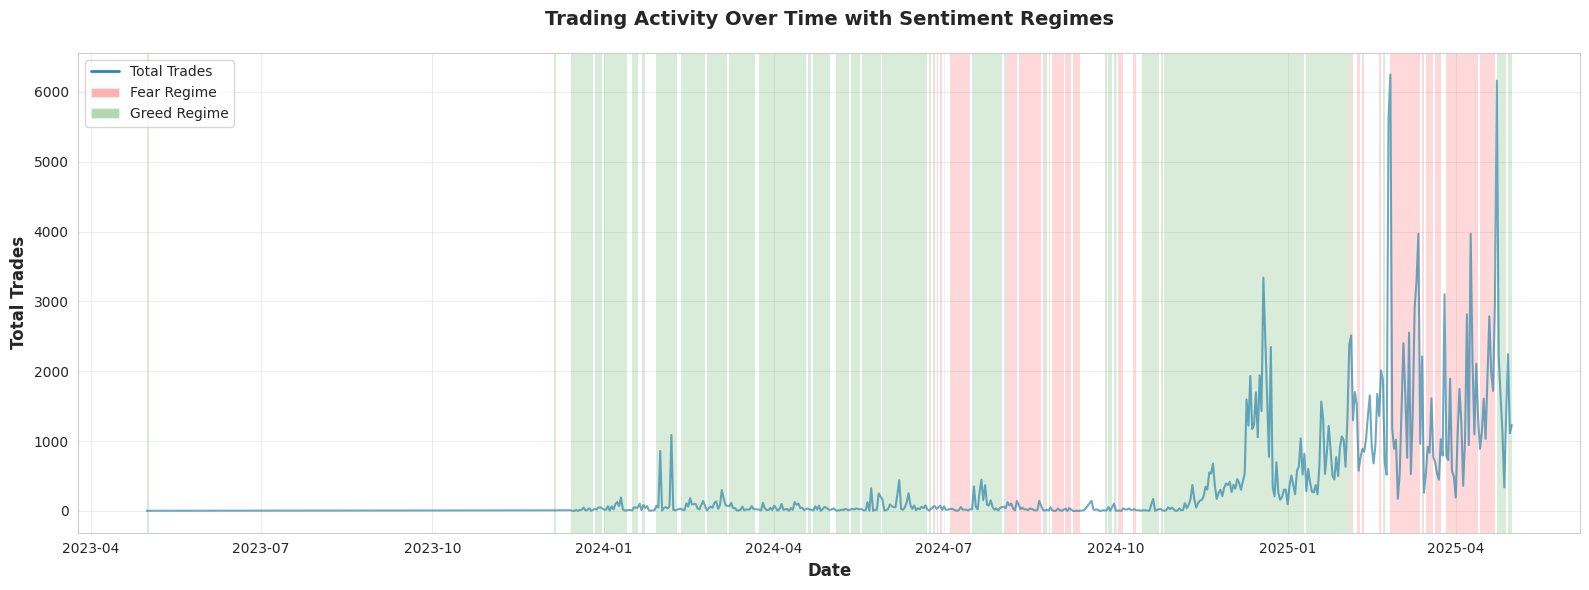


 Conclusion: Greed regimes coincide with smoother, more stable activity. Late periods show extreme activity clustering. 
 	 Market stress periods are when most trading and most risk occur. Trading is regime-dependent, not time-uniform.



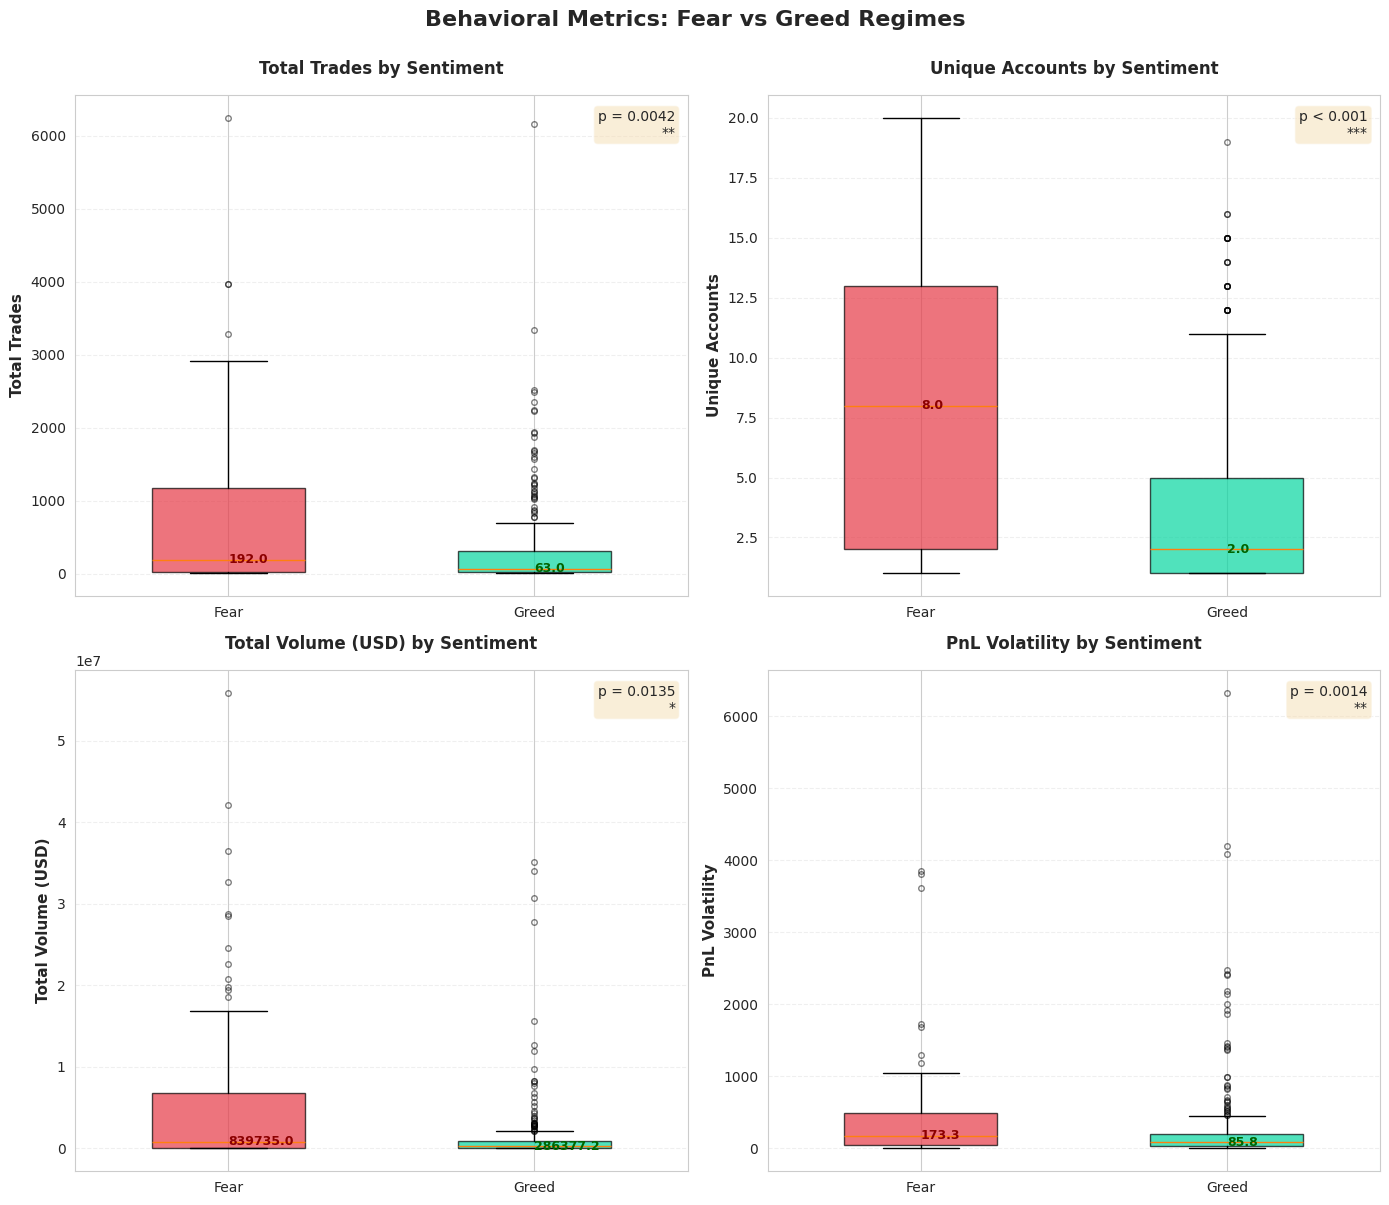


 Conclusion: Total Trades Plot: During fear regimes, traders trade more and more aggressively, reacting to uncertainty and rapid price movement. 
 	 This is classic panic-driven overtrading, not calm decision-making. Thus fear increases execution frequency but not decision quality. 

 Unique Accounts Plot: Fear brings broad participation as many traders jump in at once. This further justifies the higher number of trader in fear regime. 
 	 Greed is more concentrated, driven by fewer, more confident participants. 

 Trade Volume Plot: Fear is associated with capital reallocation at scale—liquidations, stop-outs, and defensive repositioning dominate volume. 
 	 This signifies panic behaviour and measures to losses. 

 PnL Volitality Plot: Fear regimes shows higher median volatility and much wider spread showing instability. Greed regimes are tighter and more stable. 



STATISTICAL SUMMARY: FEAR VS GREED COMPARISON
------------------------------------------------------------------------

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

daily_behavior_with_sentiment = pd.read_csv('/content/csv_files/daily_behavior_with_sentiment.csv')
daily_behavior_with_sentiment['date'] = pd.to_datetime(daily_behavior_with_sentiment['date'])

fear_sentiments = ['Fear', 'Extreme Fear']
greed_sentiments = ['Greed', 'Extreme Greed']

daily_behavior_with_sentiment['sentiment_group'] = daily_behavior_with_sentiment['sentiment'].apply(
    lambda x: 'Fear' if x in fear_sentiments else ('Greed' if x in greed_sentiments else 'Neutral')
)

plot_data = daily_behavior_with_sentiment[
    daily_behavior_with_sentiment['sentiment_group'].isin(['Fear', 'Greed'])
].copy()

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Plot 1: Time series showing trading activity with sentiment regime overlay
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(daily_behavior_with_sentiment['date'],
        daily_behavior_with_sentiment['total_trades'],
        color='#2E86AB', linewidth=1.5, alpha=0.7, label='Total Trades')

fear_mask = daily_behavior_with_sentiment['sentiment'].isin(fear_sentiments)
greed_mask = daily_behavior_with_sentiment['sentiment'].isin(greed_sentiments)

for i in range(len(daily_behavior_with_sentiment)):
    if fear_mask.iloc[i]:
        ax.axvspan(daily_behavior_with_sentiment['date'].iloc[i],
                   daily_behavior_with_sentiment['date'].iloc[i] + pd.Timedelta(days=1),
                   alpha=0.15, color='red', linewidth=0)

for i in range(len(daily_behavior_with_sentiment)):
    if greed_mask.iloc[i]:
        ax.axvspan(daily_behavior_with_sentiment['date'].iloc[i],
                   daily_behavior_with_sentiment['date'].iloc[i] + pd.Timedelta(days=1),
                   alpha=0.15, color='green', linewidth=0)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Trades', fontsize=12, fontweight='bold')
ax.set_title('Trading Activity Over Time with Sentiment Regimes',
             fontsize=14, fontweight='bold', pad=20)

from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color='#2E86AB', linewidth=2, label='Total Trades'),
    Patch(facecolor='red', alpha=0.3, label='Fear Regime'),
    Patch(facecolor='green', alpha=0.3, label='Greed Regime')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/csv_files/plot_a_timeseries_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Conclusion: Greed regimes coincide with smoother, more stable activity. Late periods show extreme activity clustering. \n \t Market stress periods are when most trading and most risk occur. Trading is regime-dependent, not time-uniform.\n")

# Plot 2: Four boxplots comparing key behavioral metrics across Fear vs Greed regimes
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

metrics_config = [
    {
        'metric': 'total_trades',
        'title': 'Total Trades by Sentiment',
        'ylabel': 'Total Trades',
        'position': (0, 0),
        'color_palette': ['#E63946', '#06D6A0']
    },
    {
        'metric': 'unique_accounts',
        'title': 'Unique Accounts by Sentiment',
        'ylabel': 'Unique Accounts',
        'position': (0, 1),
        'color_palette': ['#E63946', '#06D6A0']
    },
    {
        'metric': 'total_volume_usd',
        'title': 'Total Volume (USD) by Sentiment',
        'ylabel': 'Total Volume (USD)',
        'position': (1, 0),
        'color_palette': ['#E63946', '#06D6A0']
    },
    {
        'metric': 'pnl_volatility',
        'title': 'PnL Volatility by Sentiment',
        'ylabel': 'PnL Volatility',
        'position': (1, 1),
        'color_palette': ['#E63946', '#06D6A0']
    }
]

for config in metrics_config:
    row, col = config['position']
    ax = axes[row, col]

    metric_data = plot_data[['sentiment_group', config['metric']]].dropna()

    fear_values = metric_data[metric_data['sentiment_group'] == 'Fear'][config['metric']]
    greed_values = metric_data[metric_data['sentiment_group'] == 'Greed'][config['metric']]

    if len(fear_values) > 0 and len(greed_values) > 0:
        stat, p_value = stats.mannwhitneyu(fear_values, greed_values, alternative='two-sided')
    else:
        p_value = np.nan

    bp = ax.boxplot([fear_values, greed_values],
                     tick_labels=['Fear', 'Greed'],
                     patch_artist=True,
                     widths=0.5,
                     showfliers=True,
                     flierprops=dict(marker='o', markersize=4, alpha=0.5))

    bp['boxes'][0].set_facecolor('#E63946')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#06D6A0')
    bp['boxes'][1].set_alpha(0.7)

    ax.set_ylabel(config['ylabel'], fontsize=11, fontweight='bold')
    ax.set_title(config['title'], fontsize=12, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    fear_median = fear_values.median()
    greed_median = greed_values.median()

    if not np.isnan(p_value):
        if p_value < 0.001:
            p_text = 'p < 0.001'
        else:
            p_text = f'p = {p_value:.4f}'

        sig_text = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'ns'))

        stats_text = f'{p_text}\n{sig_text}'
        ax.text(0.98, 0.97, stats_text,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.text(1, fear_median, f'{fear_median:.1f}',
            ha='left', va='center', fontsize=9, color='darkred', fontweight='bold')
    ax.text(2, greed_median, f'{greed_median:.1f}',
            ha='left', va='center', fontsize=9, color='darkgreen', fontweight='bold')

plt.suptitle('Behavioral Metrics: Fear vs Greed Regimes',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('/content/csv_files/plot_b_boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Conclusion: Total Trades Plot: During fear regimes, traders trade more and more aggressively, reacting to uncertainty and rapid price movement. \n \t This is classic panic-driven overtrading, not calm decision-making. Thus fear increases execution frequency but not decision quality. \n")
print(" Unique Accounts Plot: Fear brings broad participation as many traders jump in at once. This further justifies the higher number of trader in fear regime. \n \t Greed is more concentrated, driven by fewer, more confident participants. \n")
print(" Trade Volume Plot: Fear is associated with capital reallocation at scale—liquidations, stop-outs, and defensive repositioning dominate volume. \n \t This signifies panic behaviour and measures to losses. \n")
print(" PnL Volitality Plot: Fear regimes shows higher median volatility and much wider spread showing instability. Greed regimes are tighter and more stable. \n")
print("\n" )

print("STATISTICAL SUMMARY: FEAR VS GREED COMPARISON")
print("-"*80)

for config in metrics_config:
    metric = config['metric']
    metric_data = plot_data[['sentiment_group', metric]].dropna()

    fear_values = metric_data[metric_data['sentiment_group'] == 'Fear'][metric]
    greed_values = metric_data[metric_data['sentiment_group'] == 'Greed'][metric]

    if len(fear_values) > 0 and len(greed_values) > 0:
        stat, p_value = stats.mannwhitneyu(fear_values, greed_values, alternative='two-sided')

        pct_diff = ((fear_values.median() - greed_values.median()) / greed_values.median() * 100) if greed_values.median() != 0 else np.nan

        print(f"\n{config['title']}:")
        print(f"  Fear median: {fear_values.median():.2f} (n={len(fear_values)})")
        print(f"  Greed median: {greed_values.median():.2f} (n={len(greed_values)})")
        print(f"  Difference: {pct_diff:+.1f}%")
        print(f"  Mann-Whitney U p-value: {p_value:.6f}")
        print(f"  Significance: {'***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'ns'))}")

